In [1]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

Definisco la seguente funzione per generare, in maniera casuale, i dati iniziali per GMRES:
- `A`: la matrice (sparsa) dei coefficienti del Sistema Lineare
- `b`: il vettore dei termini noti del Sistema Lineare
- `x0`: il guess iniziale

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

Implementazione di GMRES con l'iterazione di Arnoldi e il metodo dell'Ortogonalizzazione

In [5]:
function [x res] = mygmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k
        v = A*Q(:, j);  
        
        % ortogonalizzazione
        for _ = 1:2
            for i = 1:j
                tmp = Q(:,i)' * v;
                v = v - tmp * Q(:, i);
                H(i,j) += tmp;
            end
        end

        H(j+1, j) = norm(v, 2);
        
        % TODO: capire come gestire la divisone per 0
        if (H(j+1, j) == 0)
            error("Divisione per 0 !!");
        end
        
        Q(:, j+1) = v / H(j+1, j);

        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('🚀 Raggiunta Tolleranza, stop');
            figure();
            imagesc(H(1:j, 1:j));
            title("Matrix H");
            return;
        end
    end
    
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    figure();
    imagesc(H);  % TODO: plottare meglio
    title("Matrix H");
endfunction

## Test 1 - Random Matrix

Genero un Sistema Lineare e il guess in modo casuale per testare le perofrmance di GMRES.

In [6]:
[A, b, x0] = generateData(300, .5);

Mostro a video i dati ottenuti:
- le prime 50 righe e colonne della matrice dei coefficienti `A`,
- il vettore dei termini noti `b`,
- il guess iniziale `x0`

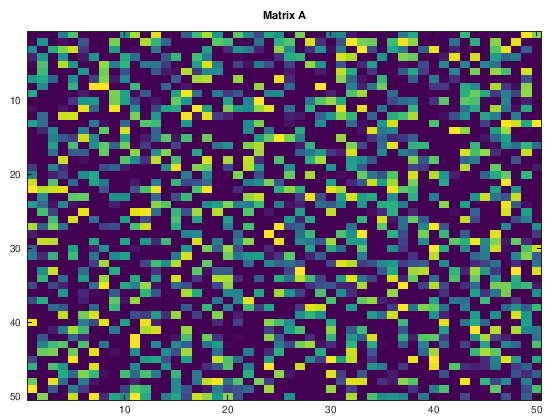

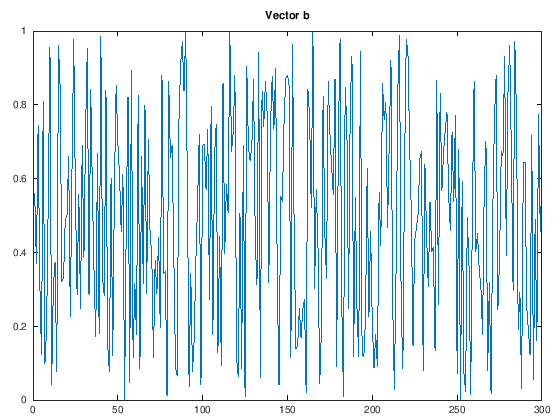

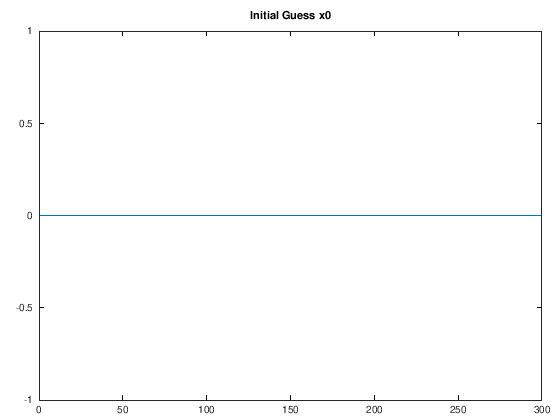

In [7]:
figure();
imagesc(A(1:50, 1:50));
title("Matrix A");

figure();
plot(b);
title("Vector b");

figure();
plot(x0);
title("Initial Guess x0");

Avvio l'esecuzione di GMRES con i dati precedentemente generati, impostando come numeoro di iterazioni 50 e tolleranza `1e-10`.

🐌 Raggiunto massimo numero di Iterazioni


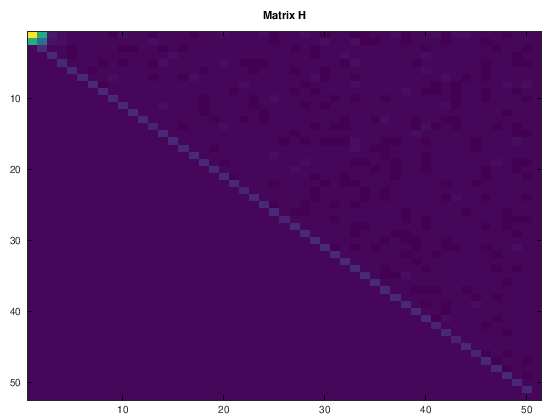

In [8]:
[x, res] = mygmres(A, b, x0, 50, 1e-10);

Mostro la soluzione `x` restituita da GMRES e la confronto con la reale soluzione al Sistema Lineare.

In [9]:
x
x_true = A\b
max(x_true-x)
approx_error = norm(x_true-x, 2)

x =

  -1.5988e-02
   1.9679e-02
   6.8196e-02
  -5.4277e-03
  -2.2284e-02
   8.8058e-03
  -1.0142e-02
   8.9331e-03
  -7.4107e-03
   1.0656e-02
  -2.9589e-02
   2.5662e-02
  -1.2659e-02
  -8.9614e-02
   4.6106e-03
  -9.4186e-03
  -1.3646e-02
  -3.3341e-02
   2.4914e-02
  -3.0541e-04
   1.5971e-02
   3.7384e-02
   1.2177e-02
   1.9394e-02
  -2.1301e-03
   1.9104e-03
  -1.3429e-02
   2.0210e-02
   1.3173e-02
   9.6206e-03
   2.3598e-02
  -3.5591e-03
  -2.1809e-02
   1.6008e-02
  -9.3330e-04
   2.5905e-02
   1.2094e-02
   3.0037e-02
  -9.7015e-03
   3.0653e-02
   1.3493e-02
   1.1854e-02
   9.7956e-03
   1.2715e-02
   3.7242e-02
  -1.6936e-02
   4.6700e-02
   2.8644e-02
   9.8020e-03
   1.6743e-02
   1.1461e-02
  -2.7865e-03
  -1.8973e-02
   1.0275e-02
   1.7969e-02
  -1.5836e-03
   1.5892e-02
   8.3726e-04
  -7.9172e-03
  -7.6164e-03
  -1.2929e-02
  -8.2796e-03
   1.6504e-02
  -1.9836e-02
   7.7715e-03
   1.4618e-02
   6.2747e-03
   4.3014e-03
   3.5323e-03
   2.5035e-02
  -1.2990e-02
 

Stampo l'andamento del residual all'avanzare delle iterazioni.

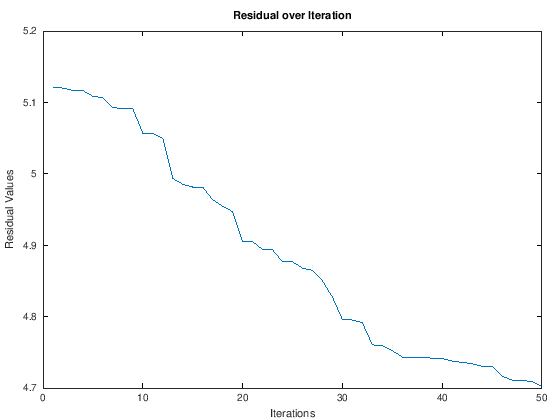

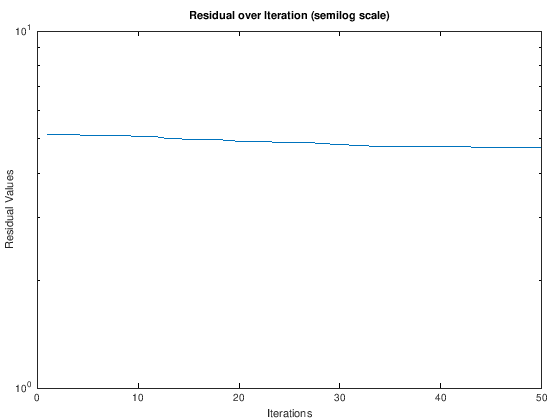

In [10]:
figure();
plot(res);
title("Residual over Iteration");
xlabel("Iterations");
ylabel("Residual Values");

figure();
semilogy(res);
title("Residual over Iteration (semilog scale)");
xlabel("Iterations");
ylabel("Residual Values");


Definisco ora una fuzione per stampare i valori dei Residuals.

In [11]:
function plotResiduals(res, all=false)
    if (all)
        figure();
        plot(res);
        title("Residual over Iteration");
        xlabel("Iterations");
        ylabel("Residual Values");
    end

    figure();
    semilogy(res);
    title("Residual over Iteration (semilog scale)");
    xlabel("Iterations");
    ylabel("Residual Values");

endfunction

Provo ad impostare come numero di iterazioni la dimensione della matrice e vedo come si comporta GMRES.

🚀 Raggiunta Tolleranza, stop
approx_error =    1.1696e-12


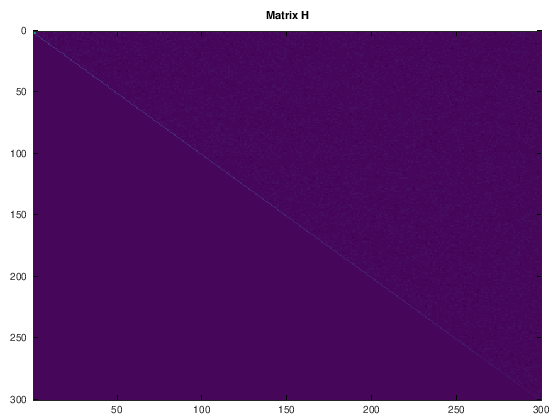

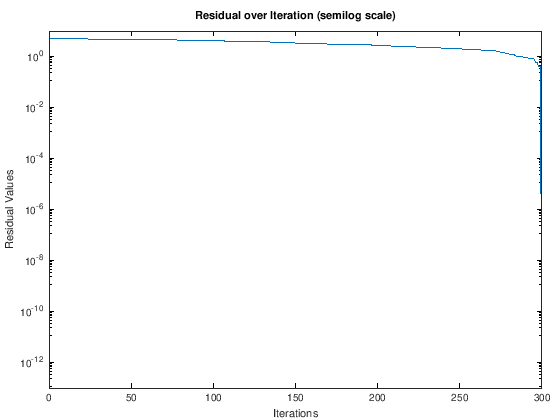

In [12]:
[x, res] = mygmres(A, b, x0, 300, 1e-10);
approx_error = norm(x_true-x, 2)

plotResiduals(res);

## Test 2 

Provo ad aumentare le dimensioni del sistema per vedere come performa GMRES con un input di medie dimensioni.

🐌 Raggiunto massimo numero di Iterazioni


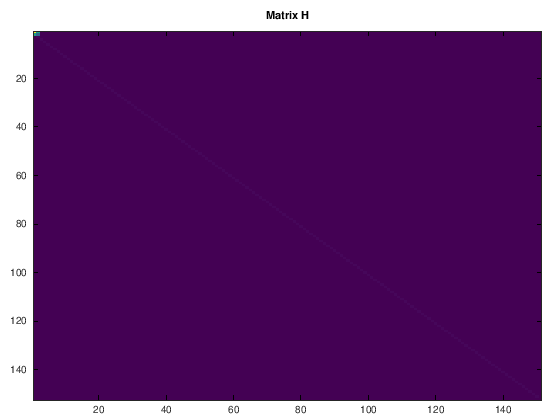

In [13]:
[A, b, x0] = generateData(10000, .5);
[x, res] = mygmres(A, b, x0, 150, 1e-10);

In [14]:
% x
x_true = A\b;
max(x_true-x)
approx_error = norm(x_true-x, 2)

x =

   1.1146e-03
  -1.3955e-03
   8.1334e-04
   4.6542e-04
   1.5644e-03
   8.6169e-04
  -1.9277e-03
  -1.9811e-04
  -8.0541e-04
   9.4501e-04
  -3.3165e-04
   6.2740e-04
   2.0299e-03
   5.4948e-04
   1.6673e-03
  -9.2200e-04
  -8.8907e-05
   3.4799e-04
  -9.2469e-04
  -3.4081e-04
   3.7992e-04
  -6.1490e-05
  -1.1425e-03
   3.1406e-04
  -1.5029e-03
   5.5370e-04
  -7.8700e-04
   1.2143e-03
  -1.8511e-03
  -8.4423e-04
   1.3420e-03
  -1.2829e-03
  -5.8321e-04
  -1.5971e-03
   2.5094e-03
   7.4345e-04
   3.9494e-04
   2.2500e-04
   7.2231e-04
   4.1430e-04
   5.4281e-04
   4.9497e-05
   2.7947e-05
   1.7575e-04
  -2.7507e-04
  -5.9839e-04
  -1.3118e-03
  -1.3470e-03
  -1.0197e-03
  -3.0642e-03
  -1.3381e-03
   1.3311e-05
   4.4746e-04
  -7.9253e-04
   2.2576e-04
   7.7068e-04
   1.6793e-03
   5.2728e-04
   2.0633e-04
  -9.1252e-04
   3.4121e-04
   1.1870e-03
  -1.4797e-03
   9.1379e-04
   1.5802e-03
  -1.7115e-04
  -9.4679e-05
   4.8412e-04
   1.0871e-03
  -7.5156e-04
   1.4731e-03
 

x_true =

  -5.2268e-01
  -3.6795e-01
   2.8069e-01
  -7.3381e-01
   2.8935e-01
   5.3752e-02
   4.1293e-01
   1.7619e-02
  -1.8587e-01
  -3.2723e-03
  -2.2705e-01
   5.4115e-01
  -5.1354e-01
  -2.6705e-01
  -1.9842e-01
   2.9717e-01
  -7.8059e-01
   7.7901e-01
   4.4515e-01
  -4.4893e-02
   8.2045e-01
  -1.2412e-01
  -7.6046e-01
   7.5613e-03
   5.9879e-01
   8.6827e-01
  -1.1219e-01
  -3.8075e-01
  -3.0014e-01
  -1.8248e-01
   8.1017e-01
   1.2477e-01
  -3.5212e-01
   4.4320e-01
  -2.7315e-01
   2.0394e-02
  -7.3869e-01
  -1.0619e-01
   7.4223e-02
  -3.6145e-01
  -5.1422e-01
  -7.2202e-02
  -2.1066e-01
  -2.0448e-01
   3.5715e-01
   3.3069e-01
  -4.2114e-01
  -4.9447e-01
   1.7710e-01
  -3.8431e-01
  -4.8432e-01
  -2.1036e-01
  -2.3788e-01
  -5.5216e-01
  -9.4713e-02
   4.1509e-01
   2.0263e-01
   3.4063e-01
   4.1236e-01
  -2.9108e-01
   7.0683e-01
   2.3278e-01
   8.1949e-02
  -5.1849e-01
  -5.3565e-01
  -7.9621e-01
   1.5254e-01
  -2.8987e-01
   2.0381e-03
   5.6801e-01
  -6.1392e

  -2.4523e-02
  -6.4685e-02
  -1.9639e-01
   7.1178e-02
  -1.1500e-01
  -1.7494e-01
  -6.2105e-02
   2.7332e-01
  -6.8472e-01
  -2.1748e-02
   1.0272e-01
  -3.3781e-01
  -2.1904e-01
   7.5716e-02
   2.4744e-01
  -5.3146e-02
  -3.4292e-01
   7.6921e-01
  -1.0328e-01
   7.1289e-02
  -7.5179e-01
   1.0840e-02
  -1.6826e-01
  -5.0502e-02
   5.4955e-01
   1.5551e-01
   5.8333e-01
   8.5888e-01
   3.2375e-01
   5.3162e-01
   1.7830e-01
  -3.3480e-01
  -6.2187e-02
   7.5605e-01
   1.3527e-01
  -7.1271e-01
  -2.7286e-01
   4.5578e-01
   3.7787e-01
   6.4723e-01
   1.0498e-01
  -6.8556e-01
  -5.9394e-02
   5.8510e-02
  -8.3650e-01
   2.2706e-01
  -3.7511e-01
  -3.3153e-01
  -2.7573e-01
   4.5695e-02
   3.6841e-01
  -1.7723e-01
  -1.1127e-01
   5.5271e-02
  -7.1999e-04
   8.8359e-01
  -2.1466e-01
  -3.0098e-01
   1.6888e-01
   3.3303e-01
  -1.0005e-01
  -5.1094e-01
   1.8835e-02
  -1.2294e-01
   1.3974e-01
   2.0419e-01
  -2.7008e-01
   3.1025e-01
  -1.3039e-01
  -3.1431e-01
  -6.3399e-02
  -6.5

  -9.2045e-02
   1.3091e-01
   5.2706e-01
  -1.1190e+00
  -5.3495e-01
  -2.6871e-01
  -1.0963e-01
   3.5291e-01
  -3.4202e-01
   4.0367e-01
   7.6629e-02
  -2.0528e-01
   4.4354e-01
  -2.3579e-02
   1.9486e-01
  -6.0062e-01
  -1.2237e-01
   2.7085e-01
   6.9023e-01
  -4.8581e-01
   2.5754e-01
   4.1874e-01
   2.2163e-01
   4.7760e-01
  -9.8180e-01
   4.6557e-01
  -2.7554e-01
  -9.3041e-02
  -2.2357e-02
  -6.6148e-01
   6.5500e-02
   3.8223e-01
   8.3730e-02
  -2.1333e-01
  -1.0650e-01
  -1.5118e-01
  -2.2625e-01
  -5.2215e-01
  -1.8313e-02
  -2.5133e-01
   7.0189e-02
   1.8221e-01
  -6.6713e-02
   5.5462e-01
  -1.5664e-01
  -8.5797e-01
  -4.7994e-02
   8.1806e-01
  -1.2751e-02
  -1.2747e-01
   3.4507e-02
  -1.7488e-01
  -8.5721e-02
  -1.5614e-01
   1.3416e-02
  -4.3771e-01
  -7.5390e-02
  -3.1134e-01
  -2.4366e-01
  -6.6450e-01
  -6.8152e-01
   7.1576e-02
   1.0544e-01
  -6.3631e-01
  -1.8462e-01
   4.6488e-01
  -5.0874e-01
  -2.0826e-01
   4.4501e-03
  -1.8064e-01
   7.4769e-01
   2.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




   2.1539e-02
   9.1342e-01
  -6.0938e-02
  -3.1922e-01
   6.5522e-01
   8.3529e-03
  -2.6920e-01
  -6.9426e-01
   4.6878e-01
   1.7641e-02
   2.6082e-01
  -2.3267e-02
   2.1057e-01
  -1.6045e-01
   8.0085e-01
  -2.9092e-01
   1.7996e-01
  -9.4363e-02
  -2.8129e-01
   2.0085e-01
   1.8009e-01
  -1.9856e-01
  -5.7302e-01
   4.9817e-01
   1.7069e-01
   2.4510e-01
  -2.7266e-01
   3.6732e-01
  -2.0734e-01
  -1.8281e-01
  -1.4507e-01
   4.1299e-01
  -2.5124e-02
  -3.1064e-01
   2.5487e-01
  -2.2693e-01
  -5.7799e-01
   3.9062e-02
  -3.2828e-01
  -6.9470e-02
   5.4626e-01
  -1.6292e-02
   2.6034e-01
  -8.3085e-02
   5.3236e-01
  -7.2016e-01
  -3.0094e-02
   3.2980e-01
  -3.2296e-01
  -2.6589e-01
  -2.3745e-01
  -5.6613e-01
  -6.2831e-02
  -1.3965e-01
   1.4622e-01
   2.2415e-01
   1.2427e-01
   1.0199e-01
  -1.4201e-01
  -8.1174e-02
   4.9425e-01
  -1.2338e-01
   1.7363e-03
   3.6923e-01
  -2.8256e-01
   4.7493e-01
   4.6315e-01
   3.0765e-01
   4.8891e-01
  -4.2174e-01
  -2.8674e-01
   5.

   7.9993e-04
  -4.6957e-02
  -1.1605e-01
   7.1055e-02
   3.5850e-01
  -3.8698e-01
  -8.0141e-01
   8.2325e-02
  -7.4357e-02
   3.8630e-02
   2.5869e-01
  -1.4350e-01
  -4.8164e-02
   1.0538e-01
  -1.3218e-01
   4.2382e-02
  -4.7282e-01
  -4.8774e-01
  -1.6613e-01
  -4.1290e-01
  -2.7571e-01
   1.7729e-02
   3.1585e-02
   1.0660e-01
   1.5100e-02
   1.9045e-01
  -4.3886e-01
   7.6601e-02
   5.8580e-01
   2.0824e-01
  -2.8371e-01
  -5.4147e-01
   7.5729e-01
   1.9421e-01
   2.0240e-01
   6.3671e-02
  -1.5464e-01
  -1.1052e-01
   1.3128e-01
  -6.0009e-01
   2.3037e-01
  -1.4268e-01
  -2.8733e-01
   2.3362e-01
  -1.3901e-01
   1.6996e-01
   2.0390e-01
   4.0461e-02
  -5.8023e-01
   6.6617e-01
   1.9259e-01
  -6.1754e-01
  -3.0916e-01
  -6.5233e-01
  -2.7785e-01
  -5.7158e-01
   3.1459e-01
   4.1360e-01
   2.4761e-02
   2.3001e-01
   6.0530e-01
  -3.1850e-01
   2.4605e-01
  -1.7313e-01
   2.6243e-01
   3.4127e-01
   7.3561e-01
   3.6799e-04
   6.5677e-01
   2.4229e-01
   3.2382e-01
   8.4

   3.7459e-01
  -2.9194e-01
   1.1262e-01
   3.4851e-02
  -4.8471e-01
  -1.3469e-01
  -8.7355e-02
   1.4784e-01
   2.5331e-01
   1.8620e-03
  -2.0462e-01
   5.4390e-01
  -3.3372e-01
  -2.4101e-01
  -5.2529e-03
   6.6300e-02
   2.0720e-01
  -1.8136e-02
   1.1812e+00
   6.5654e-02
   3.8201e-01
   8.4612e-01
  -1.0138e-01
   1.1362e-01
  -4.8114e-02
  -1.6662e-01
   2.1098e-01
  -5.9123e-02
   5.5677e-01
  -3.4782e-01
   9.7232e-01
   3.3815e-01
  -4.0411e-01
   4.7598e-01
  -1.6817e-01
   1.6884e-01
   4.0597e-01
   8.8236e-01
   1.6128e-01
  -7.7928e-02
   7.8060e-02
  -7.8072e-02
   5.2744e-01
  -5.2683e-01
  -9.3508e-01
  -4.6643e-01
  -2.8343e-01
   8.7022e-01
   4.2494e-02
   2.3710e-01
   6.0261e-01
   8.0479e-02
  -3.2754e-01
  -3.9034e-01
  -9.9397e-01
   2.0364e-01
   6.1650e-02
   3.9868e-01
   7.3996e-02
   5.9142e-01
  -7.9795e-01
  -2.5321e-02
  -3.4777e-01
   3.8321e-01
   1.3063e-01
   2.0592e-01
   3.0822e-03
   2.1293e-02
  -4.8006e-01
   4.2026e-01
   6.2979e-01
   5.6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




   4.9010e-01
   5.9467e-01
  -9.4094e-02
  -1.9575e-01
  -3.2364e-01
  -6.7345e-01
   4.5045e-01
   4.0146e-01
  -2.1459e-01
   1.3065e-01
  -4.5097e-01
  -1.1332e-01
  -8.0989e-01
   1.1857e-02
   4.5495e-01
  -4.1980e-01
   1.6617e-01
  -1.4365e-01
  -2.2841e-01
   5.2387e-01
   5.6463e-01
  -1.2634e-01
   1.1704e-01
  -5.2159e-01
  -8.9726e-01
   3.3412e-01
   1.1566e-01
  -1.7780e-02
   4.6724e-01
  -3.1923e-01
  -6.8572e-02
  -2.4268e-01
  -2.8771e-02
  -1.6066e-01
  -2.6701e-01
  -1.6168e-01
   7.9958e-02
   6.1321e-01
  -5.8109e-01
   4.5694e-01
   2.6885e-01
   3.0088e-01
   4.4628e-02
  -5.7282e-02
  -7.3123e-01
   9.4108e-02
  -1.9638e-01
   9.3822e-02
   2.7952e-01
   4.4499e-01
  -3.1833e-01
   2.0308e-01
   5.5368e-01
   1.6269e-01
   6.5016e-01
  -3.7486e-01
  -2.7116e-01
  -3.6424e-01
  -2.1115e-01
   5.6975e-01
  -2.1095e-01
   8.4021e-01
  -3.4753e-01
   7.2505e-02
   1.4309e-02
   6.8975e-01
  -1.4899e-01
  -8.6989e-02
  -1.9562e-01
   8.4493e-02
   4.2563e-01
  -1.

  -1.1753e-02
   7.4300e-02
   2.3215e-01
   1.6118e-01
  -6.3100e-01
  -9.4489e-01
  -3.9320e-01
  -7.0690e-02
   4.5171e-01
  -1.8231e-01
   2.5421e-02
  -1.7913e-01
  -4.8329e-02
  -1.1853e-01
  -7.8627e-01
  -6.2361e-01
  -8.3053e-01
   2.5100e-01
   9.7657e-02
  -5.9116e-01
  -1.9629e-01
  -1.5191e-01
   1.3625e-01
   3.4838e-01
   1.5261e-01
  -2.0091e-01
  -1.4628e-02
  -2.7438e-01
  -5.9374e-01
   7.8973e-02
   8.3719e-02
   4.5568e-01
   3.3691e-01
   1.1850e-01
  -1.6095e-01
  -1.5403e-01
  -6.7677e-01
   5.6710e-01
  -5.2350e-01
  -1.7941e-01
   2.0959e-01
   2.6018e-01
   6.2059e-02
   3.0300e-01
  -8.6683e-02
   7.4315e-01
   1.3990e-01
  -3.0790e-03
   3.8201e-01
   1.5085e-01
  -2.7458e-01
  -1.3339e-01
   2.5399e-01
  -5.2278e-01
   5.0357e-01
   7.5182e-02
   6.1767e-01
  -3.2609e-01
   4.2651e-01
   9.9409e-02
   3.4741e-01
  -3.4807e-01
   6.7464e-02
   3.1286e-02
  -6.6334e-01
  -9.9087e-02
  -3.0531e-01
   3.0011e-01
   1.4438e-01
   4.8347e-01
  -4.6670e-02
   6.3

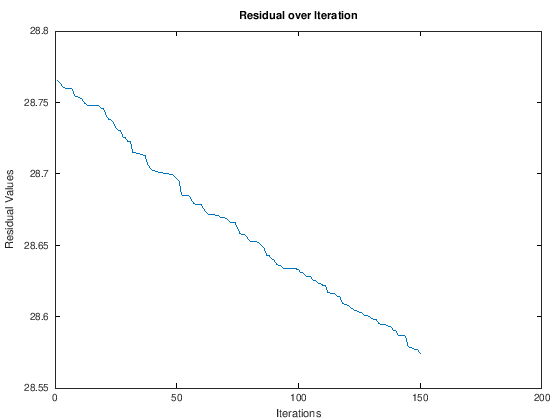

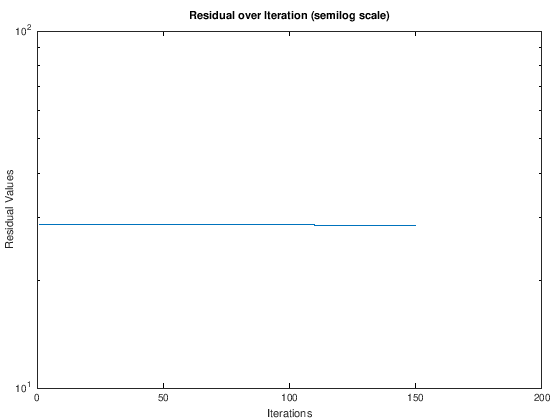

In [15]:
plotResiduals(res, all=true);

## Test 3

Analizzo le varie matrici che genero per capire quale proprietà hanno in comune.

La seguente funzione va a mostrare a video le prime 50 righe e colonne e gli eigenvalue della matrice passata in input.

In [16]:
function plotMatrix(A, figTitle="Matrix")
    figure();
    imagesc(A(1:50, 1:50));
    title(figTitle);
endfunction

function plotEig(A, figTitle="Eigenvalues")
    figure();
    plot(eig(A), 'o');
    title(figTitle);
endfunction

function matrixInfo(A, title1="Matrix", title2="Eigenvalues")
    plotMatrix(A, title1);

    plotEig(A, title2);
endfunction

Genero 4 Sistemi Lineari differenti con dimensione compresa tra 50 e 800, per rendere il calcolo degli autovalori immediato.

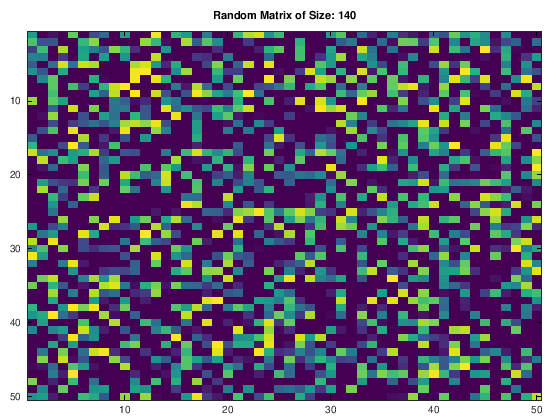

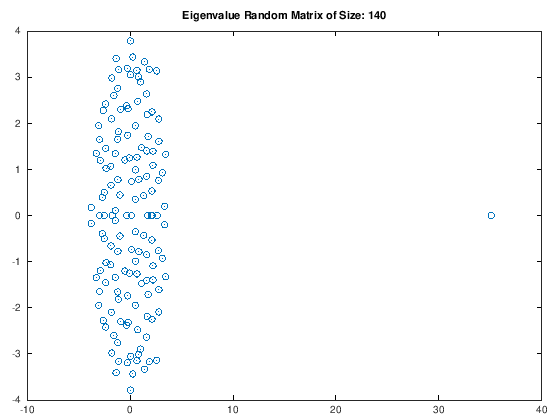

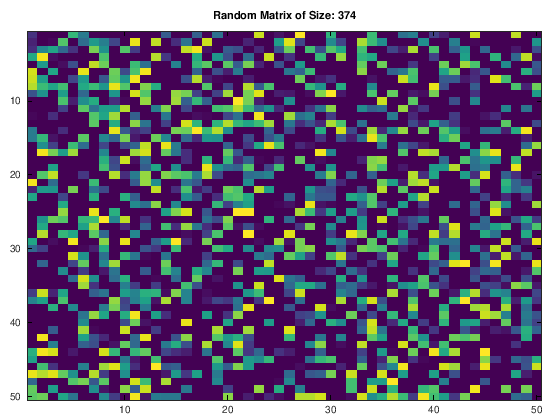

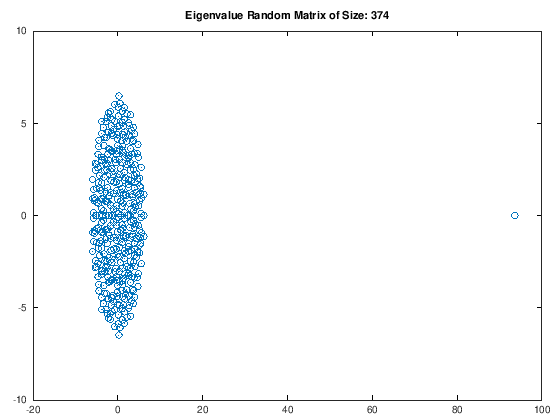

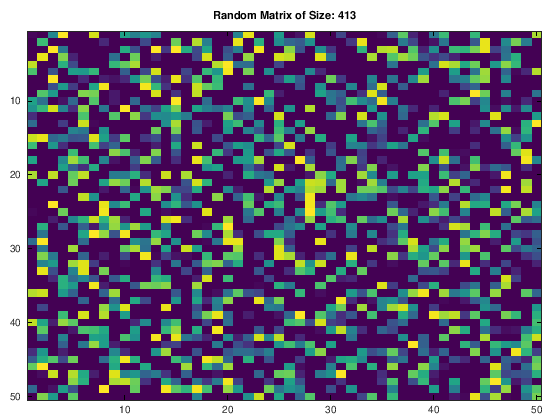

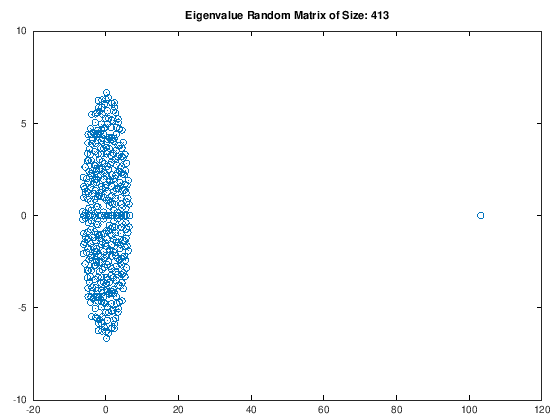

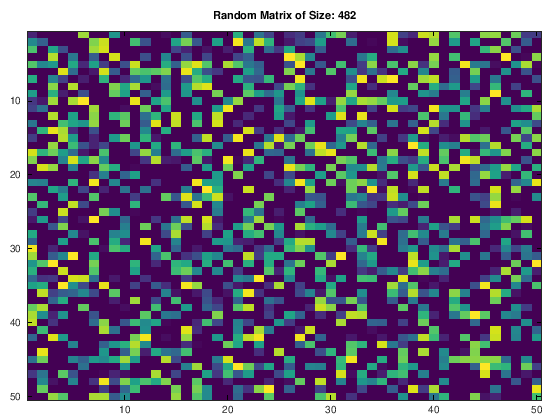

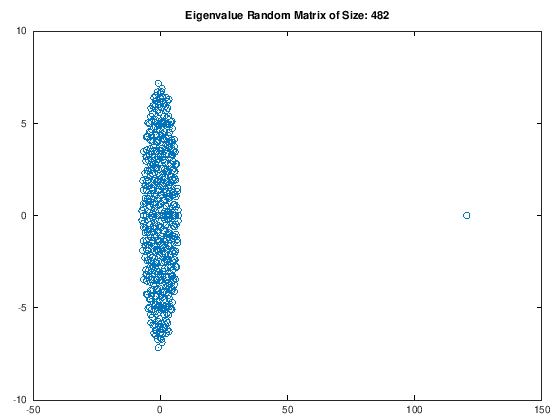

In [17]:
for _ = 1:4
    % 50 <= random size <= 800
    dim = randi([50 800], 1, 1);
    
    [A, b, x0] = generateData(dim, .5);
    
    matrixInfo(
        A, 
        title1=["Random Matrix of Size: " num2str(dim)], 
        title2=["Eigenvalue Random Matrix of Size: " num2str(dim)]
    );
end

## Test 4

Applico GMRES ad un Sistema Lineare la cui matrice dei coefficienti è l'identità.

error: Divisione per 0 !!
error: called from
    mygmres at line 29 column 13


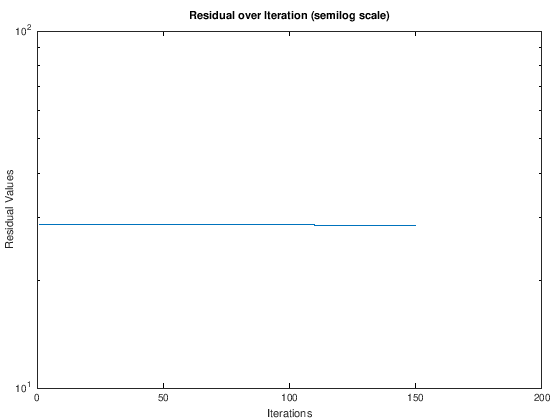

In [18]:
[A, b, x0] = generateData(300, .5);
A = eye(300);

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);

## Test 5

GMRES con multiplo della matrice identità

🚀 Raggiunta Tolleranza, stop


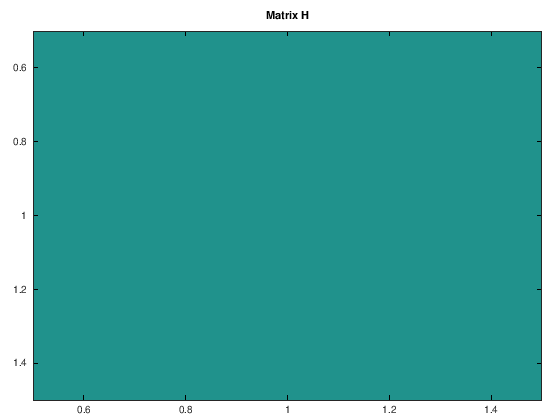

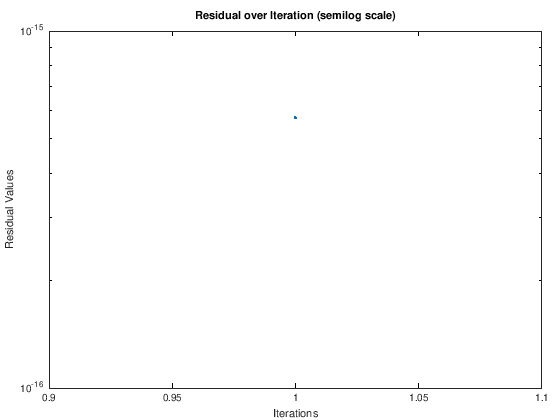

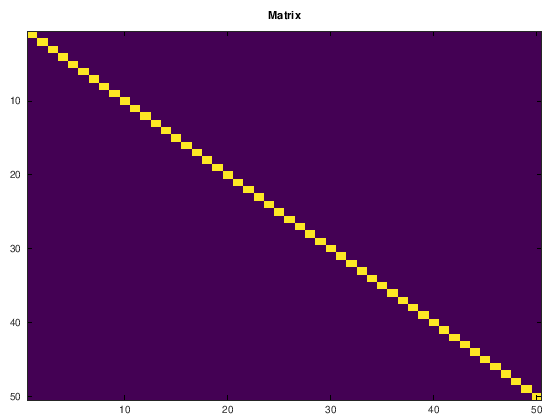

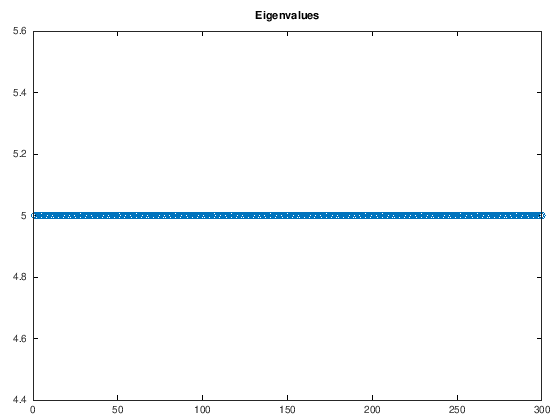

In [19]:
A = eye(300) * 5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

## Test 6

Matrice radom + multiplo identità

🐌 Raggiunto massimo numero di Iterazioni


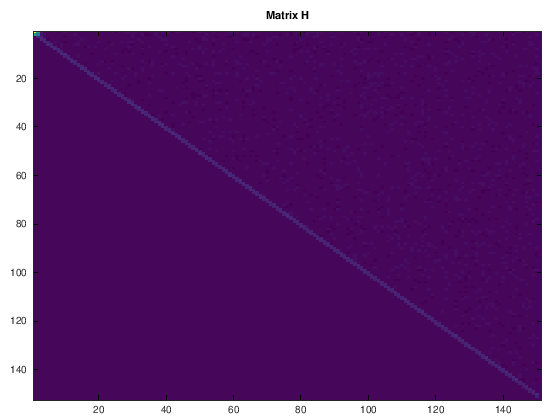

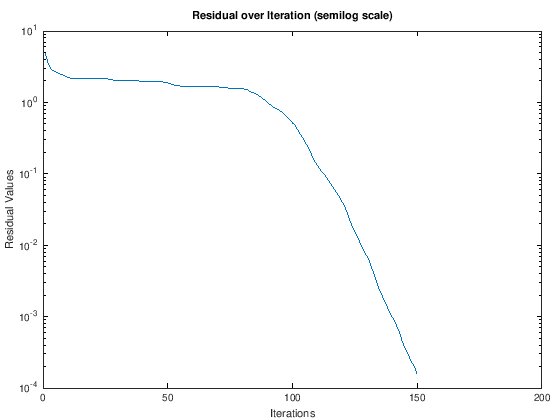

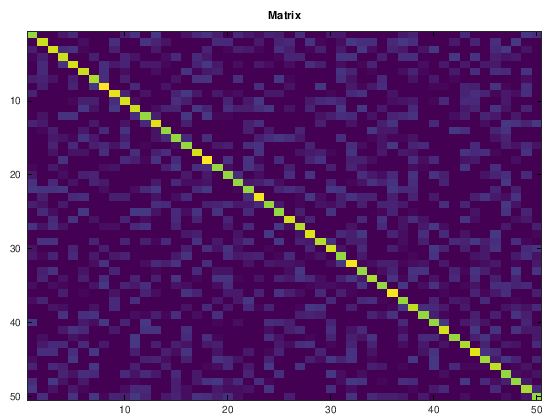

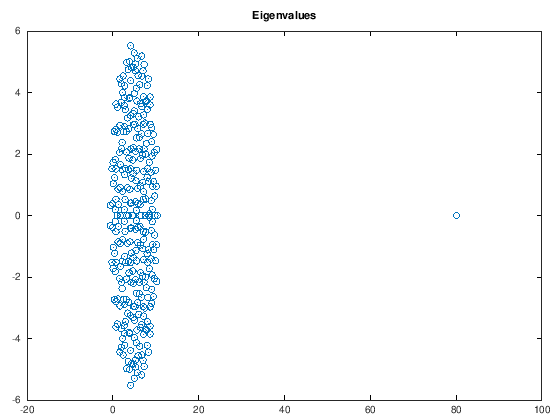

In [20]:
[A, b, x0] = generateData(300, .5);
A = A + eye(300)*5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

## Test 7

Multiplo Identità più una matrice con valori compresi tra 0 e 1

In [21]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

🚀 Raggiunta Tolleranza, stop
approx_error =    6.8220e-12
🚀 Raggiunta Tolleranza, stop
approx_error =    2.4250e-11
🐌 Raggiunto massimo numero di Iterazioni
approx_error =  518.14
🚀 Raggiunta Tolleranza, stop
approx_error =    2.3117e-11
🚀 Raggiunta Tolleranza, stop
approx_error =    7.2171e-12


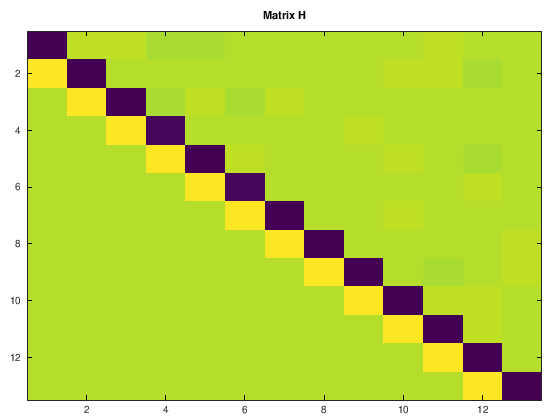

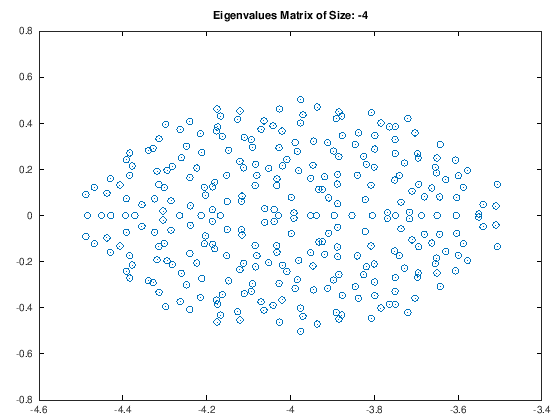

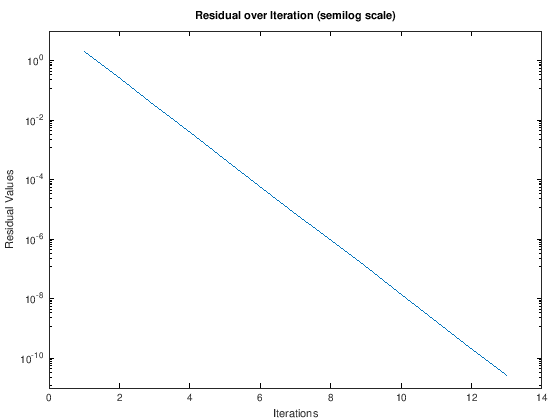

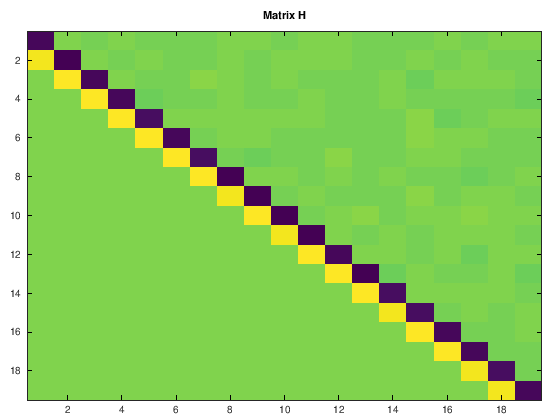

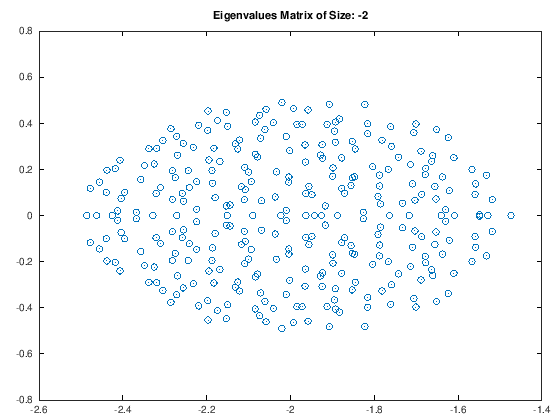

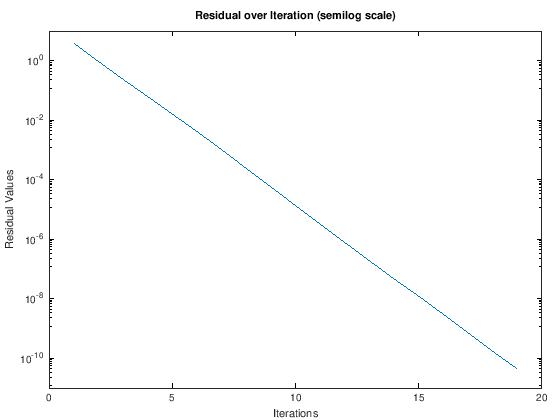

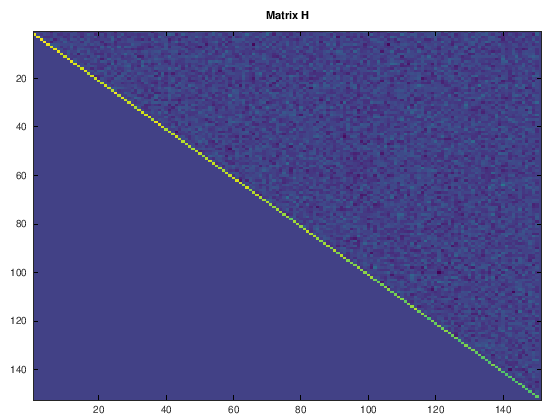

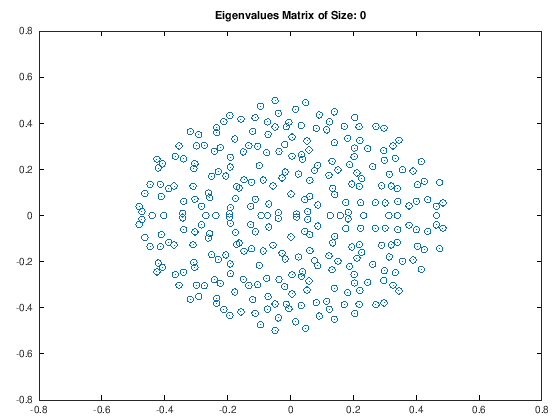

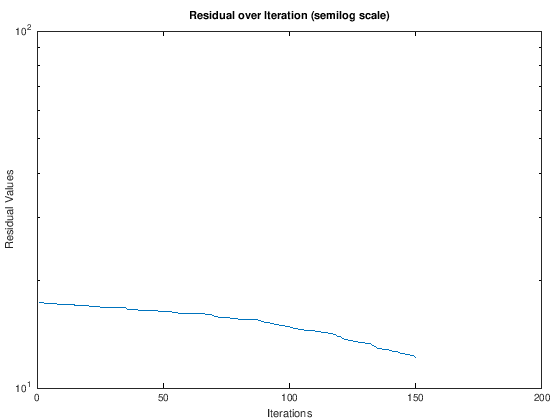

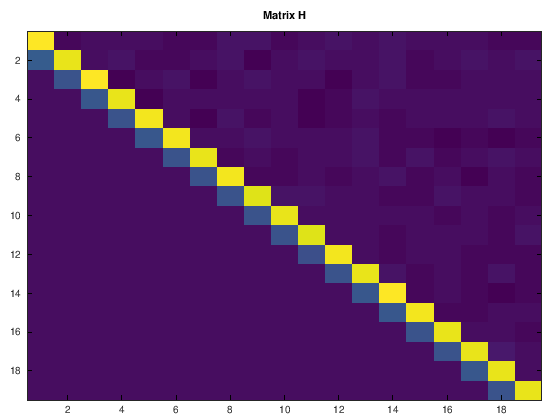

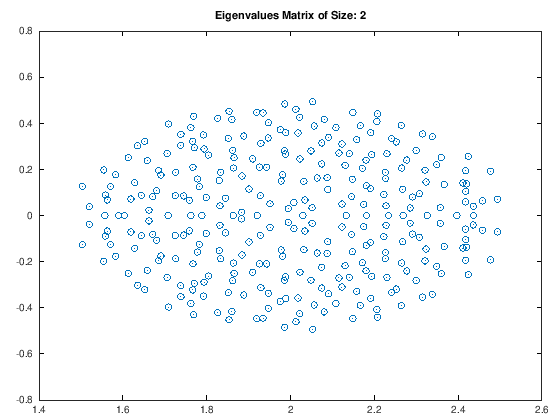

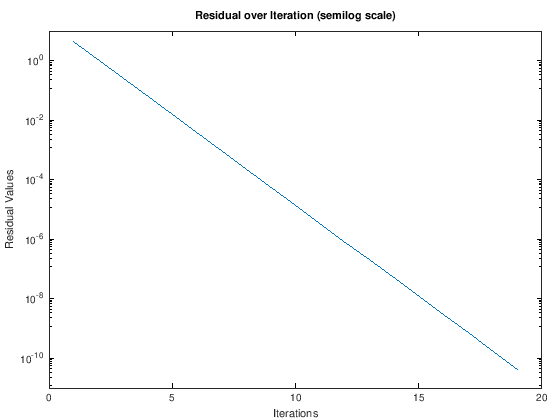

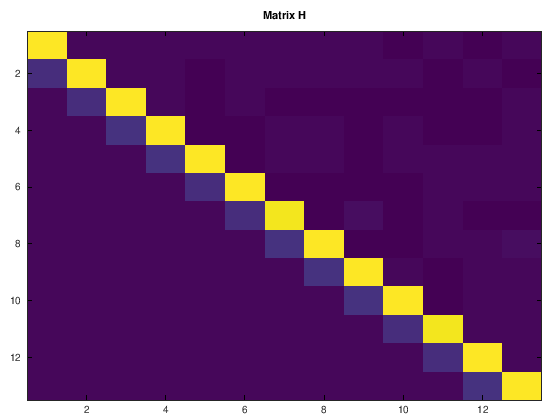

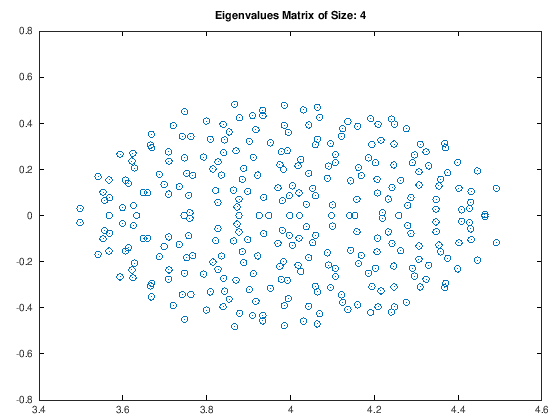

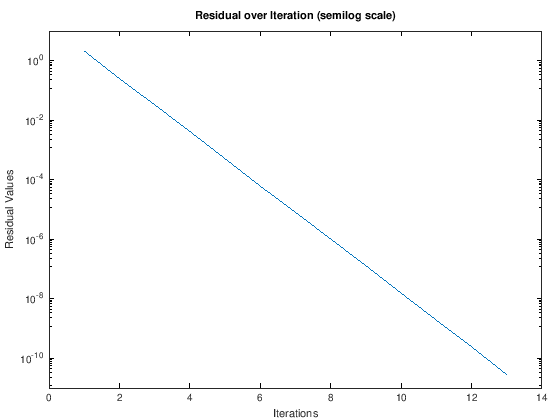

In [22]:
for n = [-4 -2 0 2 4]
%     printf("🍌 n = %d\n", n)
    
    [A, b, x0] = generateData2(300, n=n);
    [x, res] = mygmres(A, b, x0, 150, 1e-10);
    
    x_true = A\b;
    approx_error = norm(x_true-x, 2)
    
    plotEig(A, figTitle=["Eigenvalues Matrix of Size: " num2str(n)]);
    plotResiduals(res);
end

🚀 Raggiunta Tolleranza, stop


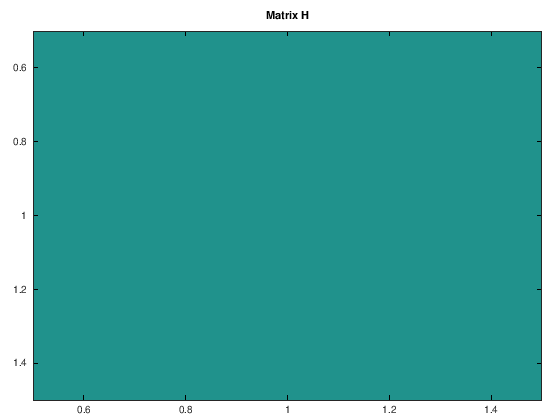

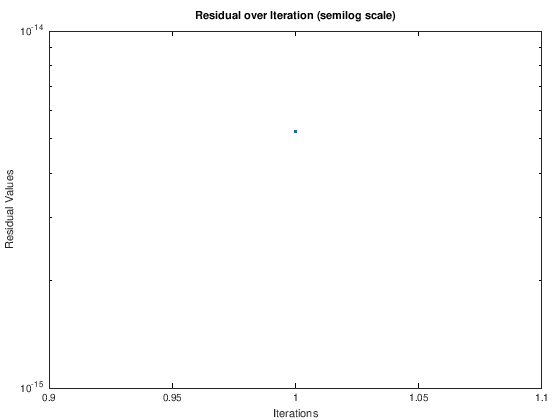

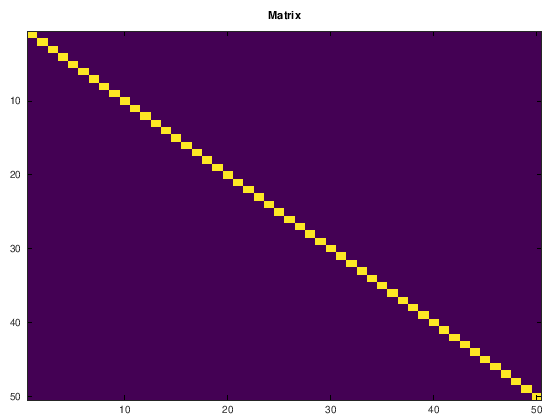

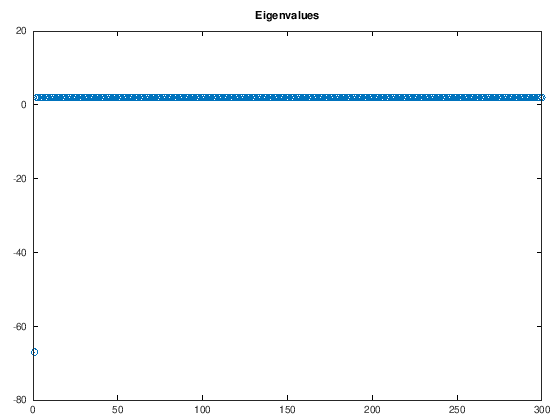

In [23]:
A = (zeros(300)-0.23) + eye(300)*2;
[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);

matrixInfo(A);

## Big Data

Provo a generare una matrice di modeste dimensioni e vedere il tempo di esecuzione di GMRES.

In [30]:
%%time
[A, b, x0] = generateData(10000, .5);

🐌 Raggiunto massimo numero di Iterazioni


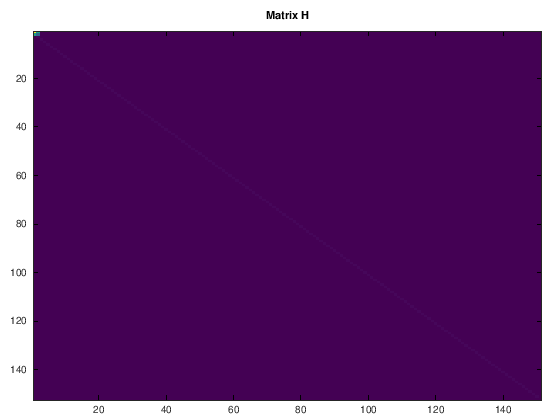

Time: 21.308188676834106 seconds.



In [31]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);

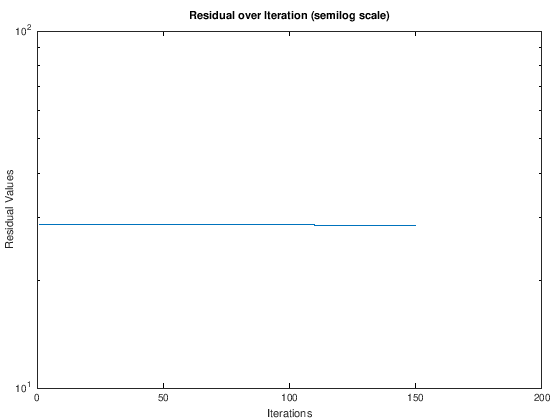

In [32]:
plotResiduals(res);

Provo a generare una matrice di grandi dimensioni che sicuramente permette a GMRES di convergere ma porbabilmente, data l'implementazione di `generateData2()`, non entrerà in memoria.

error: out of memory or dimension too large for Octave's index type
error: called from
    normrnd at line 87 column 11
    generateData2 at line 5 column 7
🐌 Raggiunto massimo numero di Iterazioni


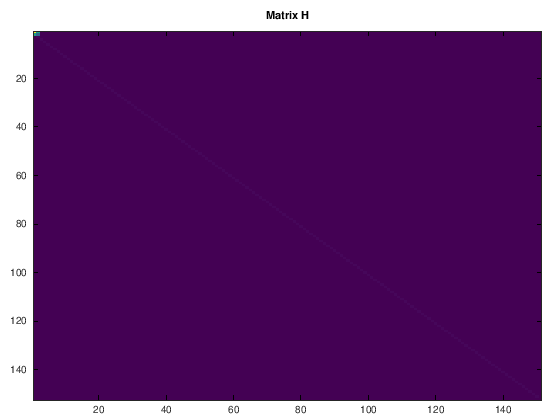

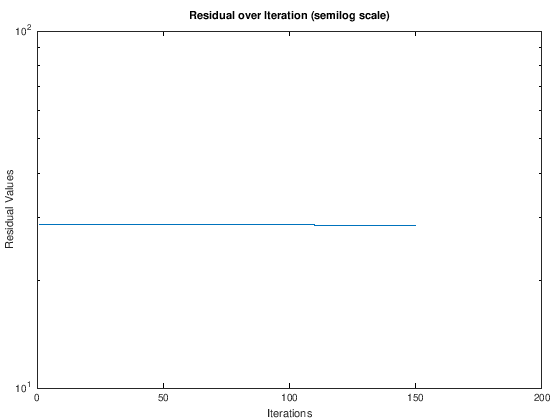

Time: 21.21574378013611 seconds.



In [33]:
[A, b, x0] = generateData2(100000, n=4);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
plotResiduals(res);

Genero una matrice di grandi dimensioni che sicuramente non permette a GMRES di entrare in memoria. Questa volta la matrice `A` è sparsa e, con il giusto valore di _densità_ riesco ad allocarla e lavorarci.

In [34]:
%%time
[A, b, x0] = generateData(100000, .1);

🐌 Raggiunto massimo numero di Iterazioni


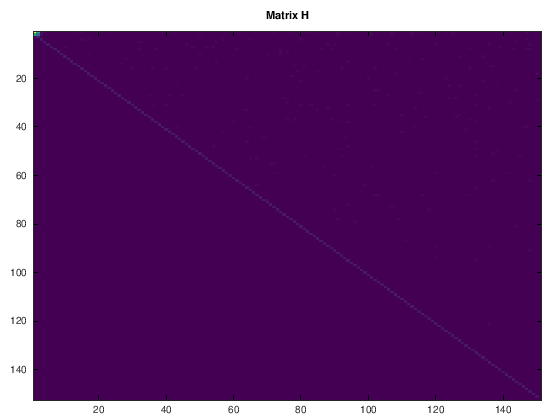

Time: 31.610414505004883 seconds.



In [35]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);

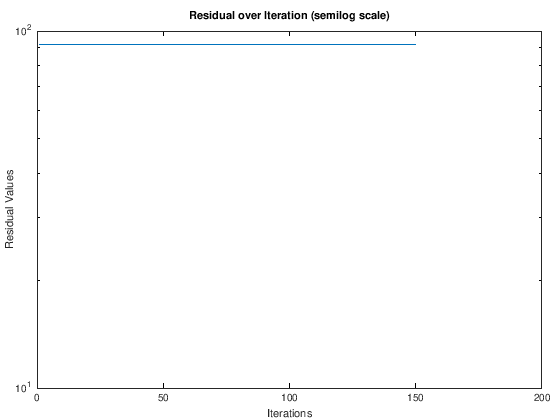

In [36]:
plotResiduals(res);

Definisco una funzione che sia in grado di generare matrici sparse che permettano a GMRES di convergere.

In [37]:
function [A b x0] = generateData3(dim, dense, n=-4, seed=69, randx0=false)
    rand("seed", seed);

    A = sprandn(dim, dim, dense)*0.01 + speye(dim)*n ;

    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

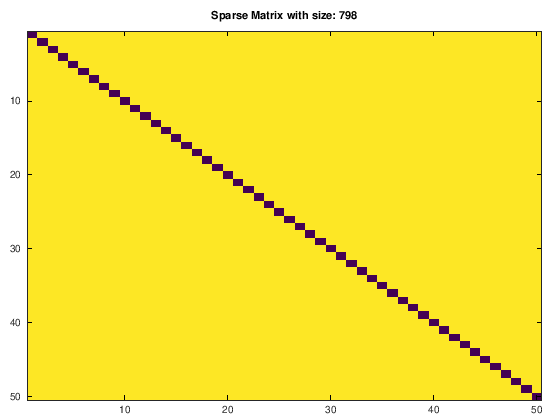

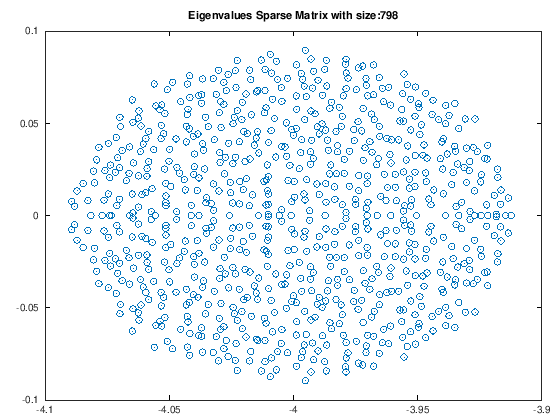

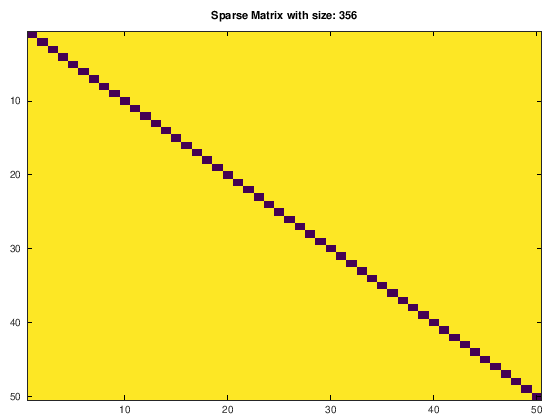

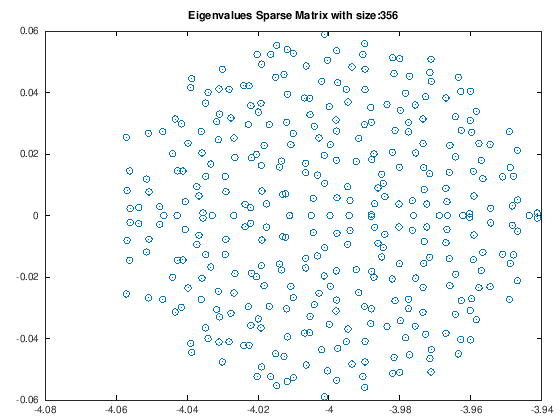

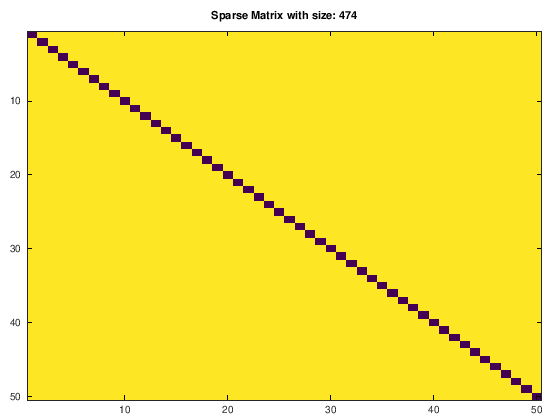

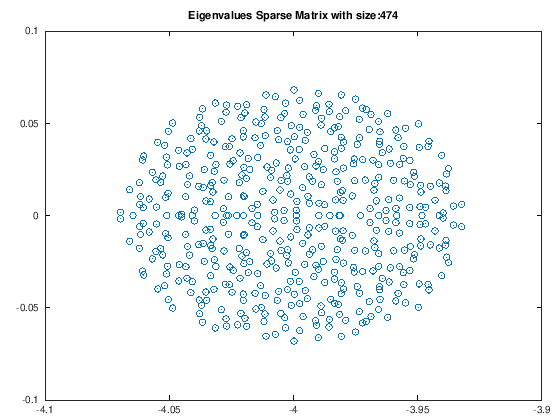

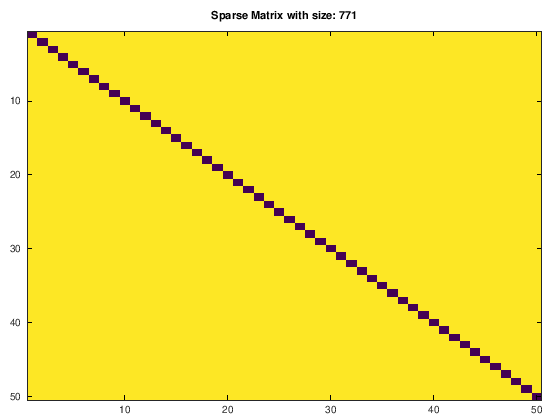

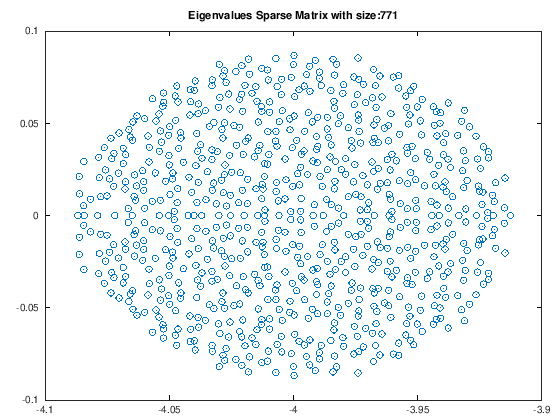

In [38]:
for _ = 1:4
    dim = randi([50 800], 1, 1);

[A b x0] = generateData3(dim, .1);
    
    matrixInfo(
        A, 
        title1=["Sparse Matrix with size: " num2str(dim)],
        title2=["Eigenvalues Sparse Matrix with size:" num2str(dim)]
    );
end

In [39]:
%%time
[A b x0] = generateData3(100000, .1);

Time: 146.6969826221466 seconds.



ans =

   100000   100000

🚀 Raggiunta Tolleranza, stop


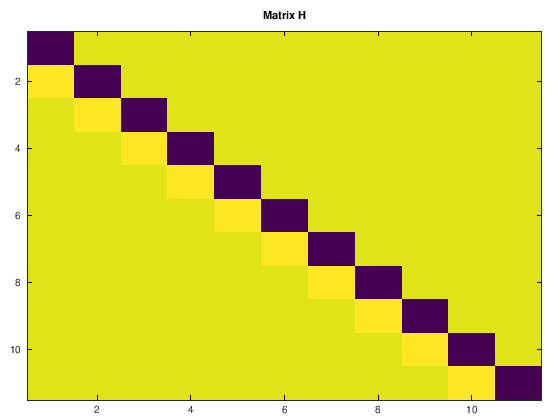

Time: 2.3716518878936768 seconds.



In [40]:
%%time
size(A)
[x, res] = mygmres(A, b, x0, 150, 1e-10);

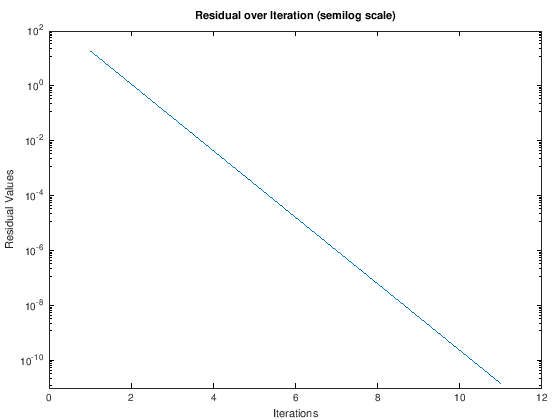

In [41]:
plotResiduals(res);

## GMRES(m)

Implementazion di GMRES con Restarting e vari test.

In [33]:
function [x res] = myrgmres(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;

    while (restartCount < m)
        H = zeros(k+2, k+1);
        Q = zeros(n, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k
            v = A*Q(:, j);  

            % ortogonalizzazione
            for _ = 1:2
                for i = 1:j
                    %H(i,j) = Q(:,i)' * v;
                    tmp = Q(:,i)' * v;
                    v = v - tmp * Q(:, i);
                    H(i,j) += tmp;
                end
            end

            % ortogonalizzazione ??
            %v = mgorth(v, Q); %% è quella bella
    %         v = gramschmidt(v);

            H(j+1, j) = norm(v, 2);

            % TODO: capire come gestire la divisone per 0
            if (H(j+1, j) == 0)
                error("Divisione per 0 !!");
            end

            Q(:, j+1) = v / H(j+1, j);

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H(1:j, 1:j));
                return;
            end
        end
        
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
        restartCount = restartCount + 1;
        
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

🚀 Raggiunta Tolleranza, stop


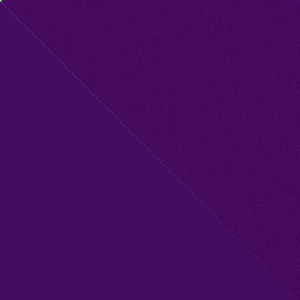

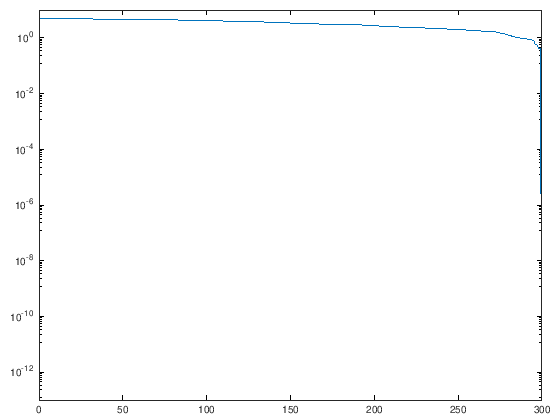

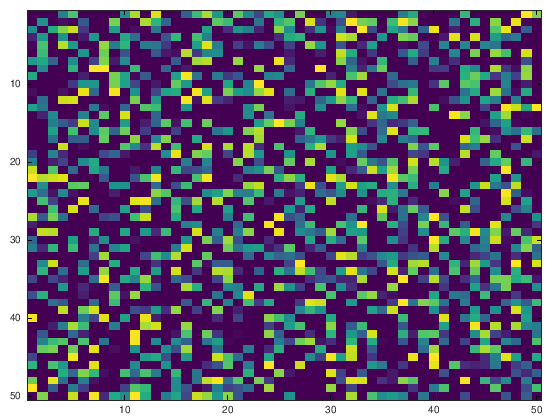

In [40]:
[A, b, x0] = generateData(9000, .5);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop
ans =    1.3054e-09


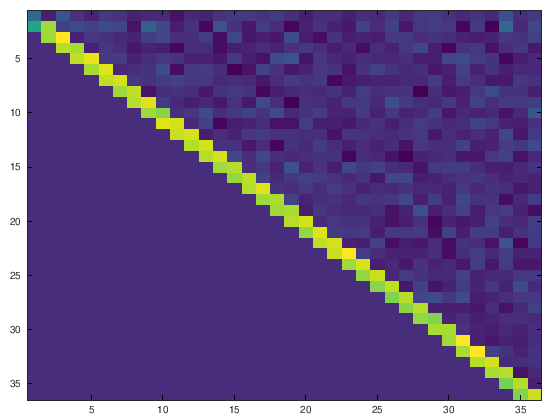

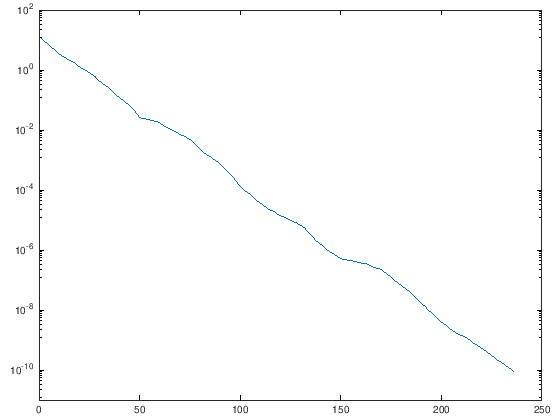

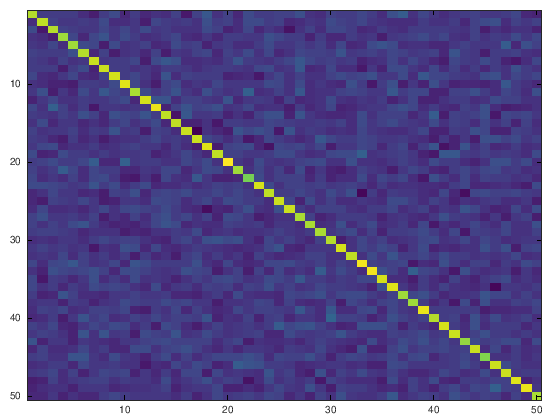

In [55]:
%questo è gustoso 🚀
[A, b, x0] = generateData2(300, .5);
figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
❌ Raggiunto massimo numero di Restart
ans =  68.967


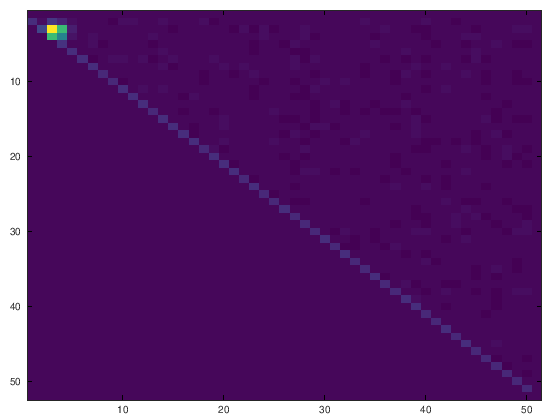

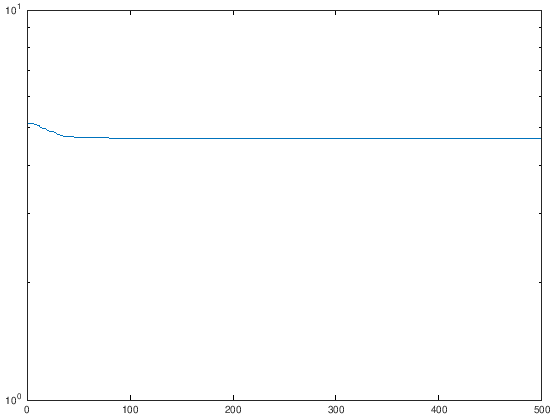

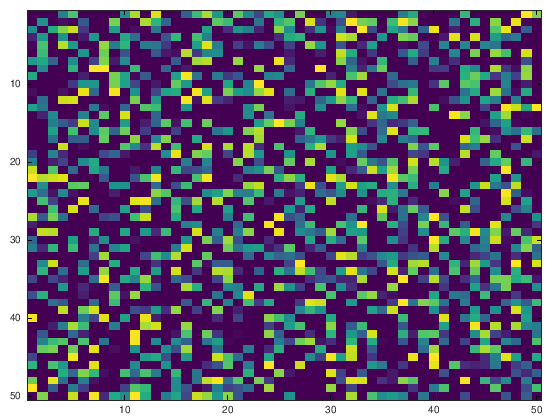

In [41]:
[A, b, x0] = generateData(300, .5);

figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

In [57]:
x_true = A\b;
norm(x_true-x, 2)

ans =  295.03


🚀 Raggiunta Tolleranza, stop
ans =    1.2095e-11


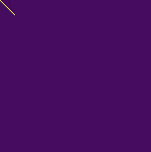

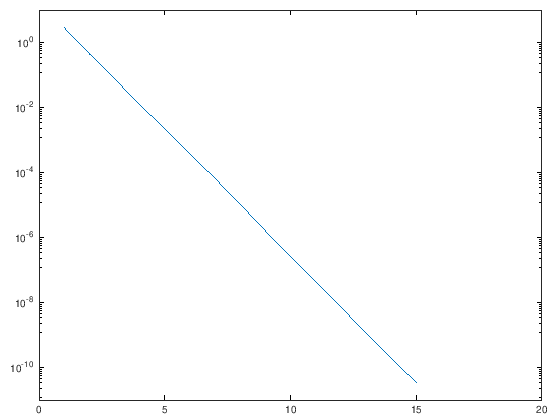

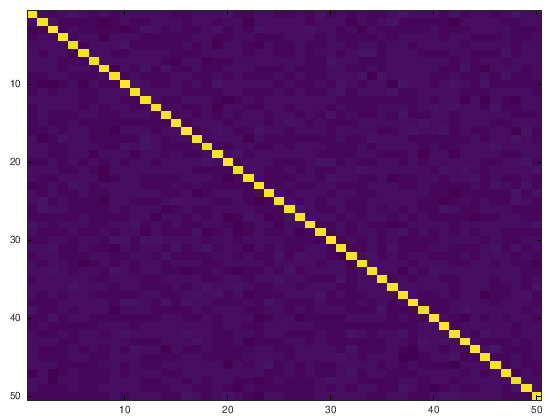

In [59]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🚀 Raggiunta Tolleranza, stop
ans =  1.1308


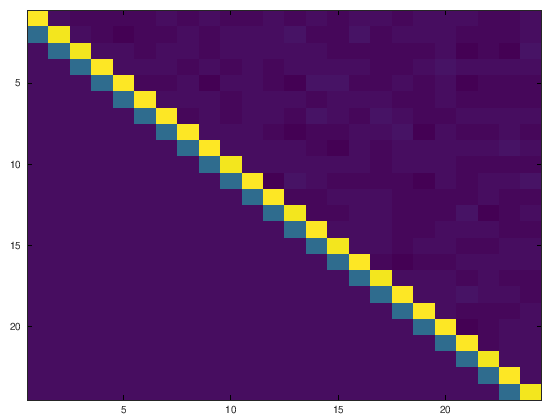

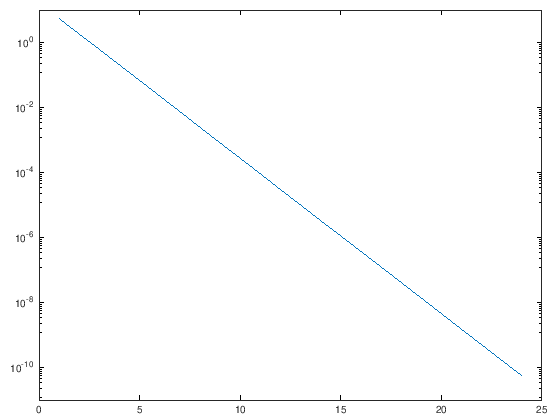

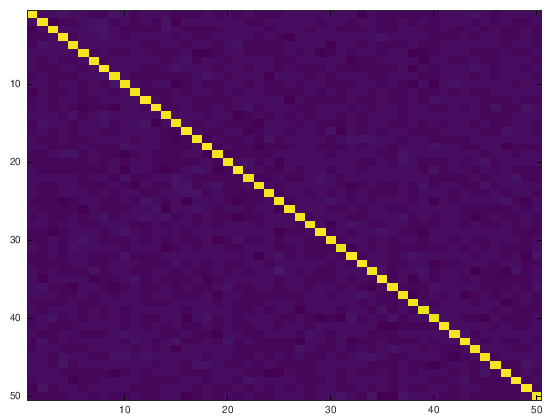

In [58]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


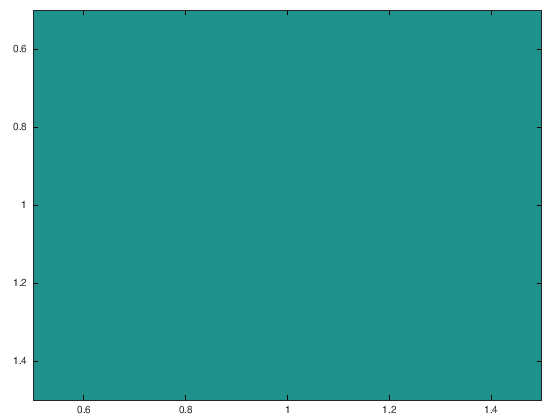

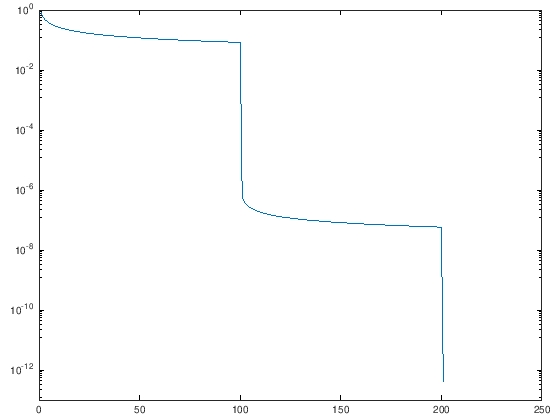

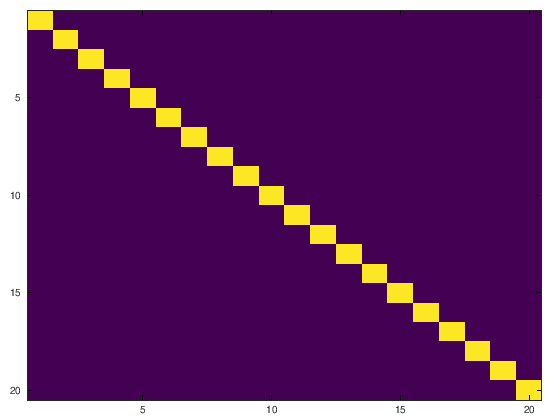

In [17]:
A = eye(10000)*120;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


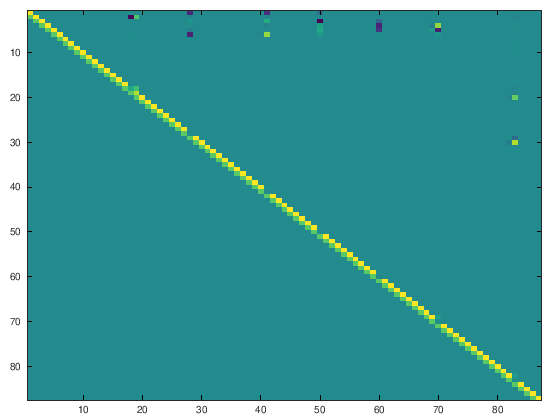

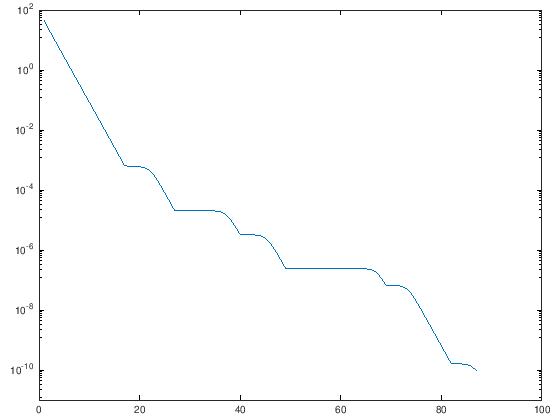

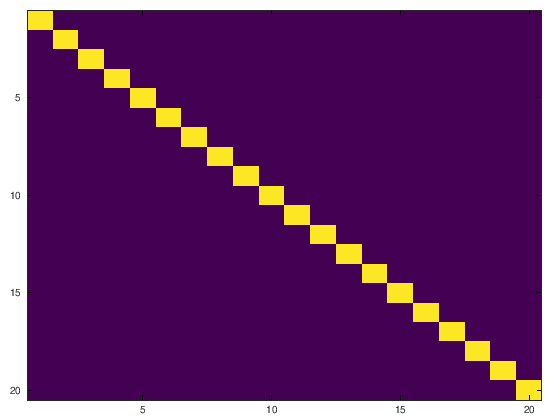

In [18]:
A = (ones(10000)-0.999999999999) + eye(10000)*2;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


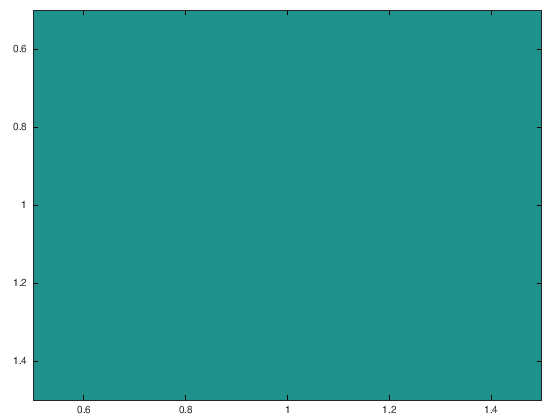

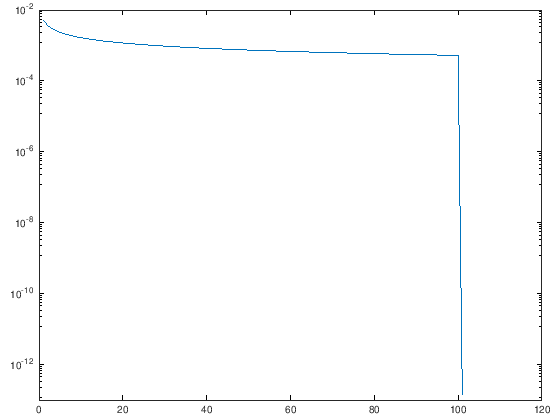

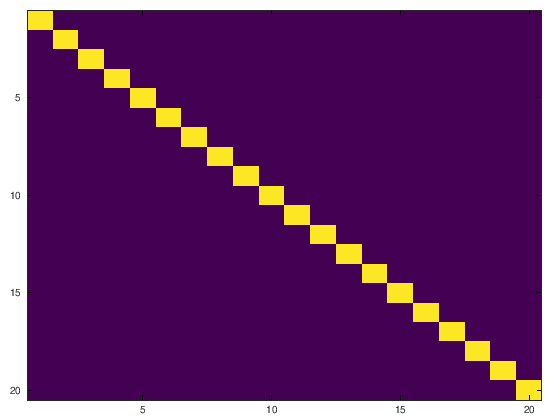

In [19]:
A = (ones(10000)+.9) + eye(10000)*3;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10354
normm =  1.8805
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.41524
normm =  4.1312
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo nume

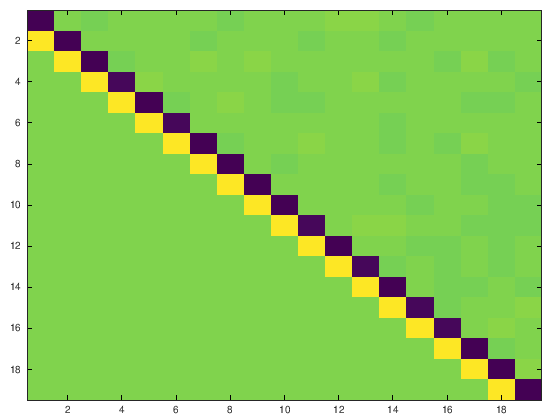

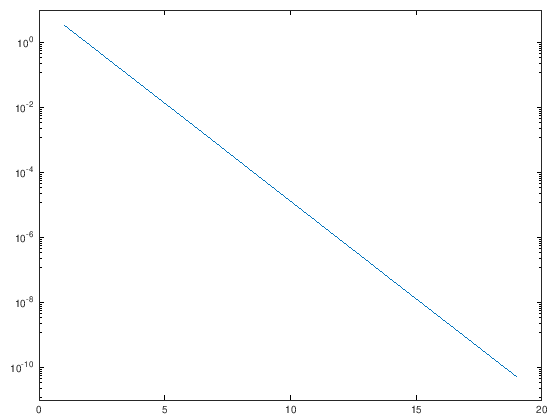

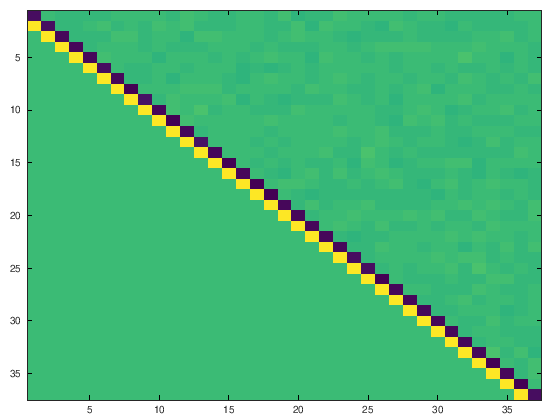

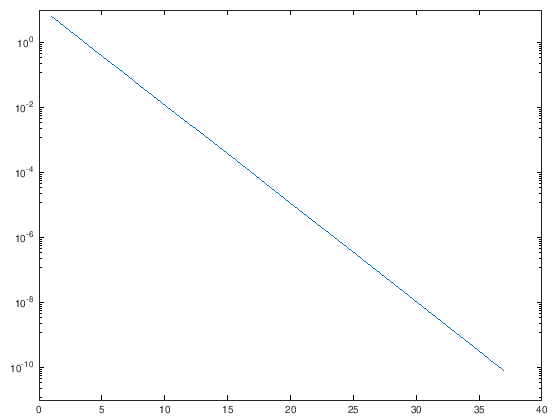

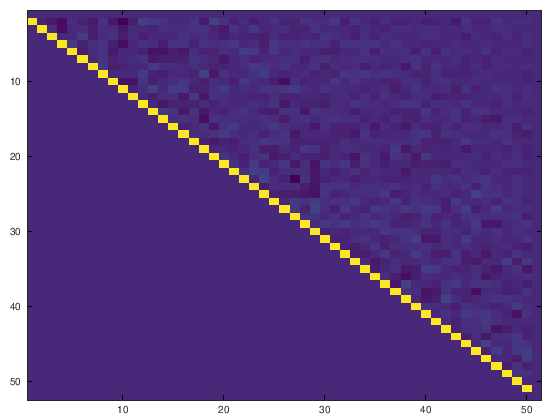

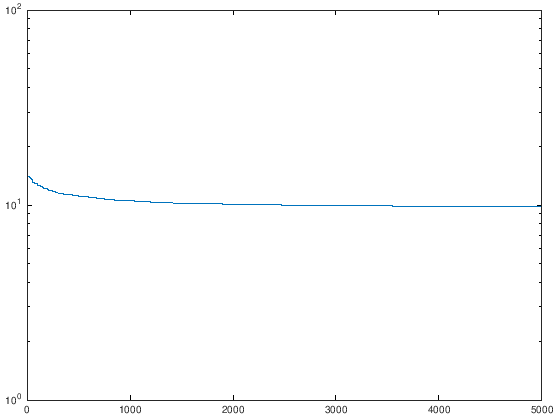

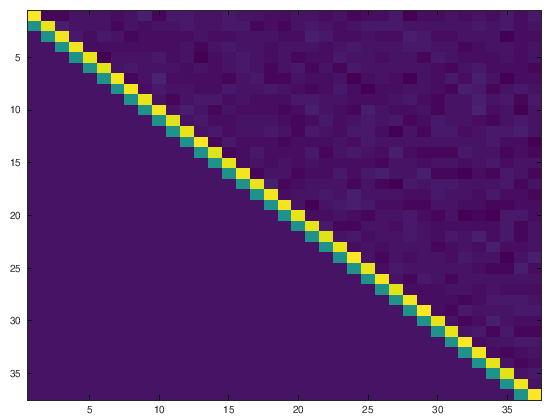

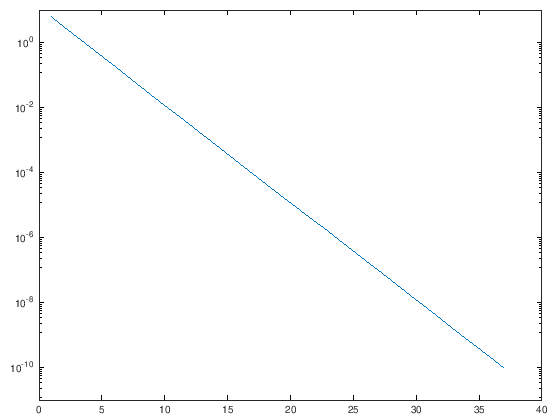

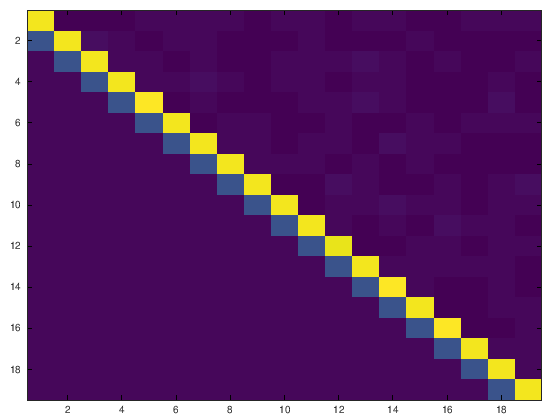

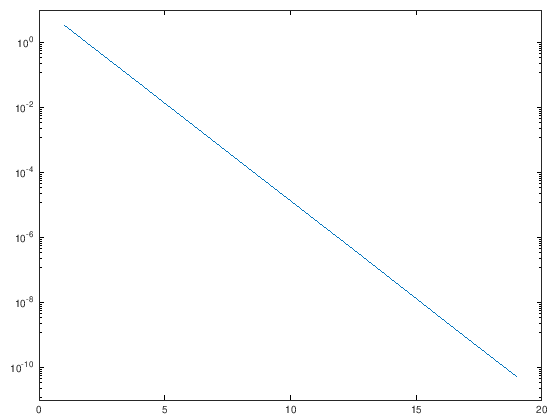

In [20]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end